In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor


from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [4]:
dockless_data = pd.read_pickle("../../data/pickled_data/dockless_data.pkl")
weather_data = pd.read_pickle("../../data/pickled_data/weather_data.pkl")

In [5]:
# TODO : Add to pipeline
# Drop all records where  trip distance is less .1 miles and greater than 500 miles (1609.34 mts - 804673 mts)
dockless_data = dockless_data[(dockless_data['Trip Distance'] > 1609.34) & (dockless_data['Trip Distance'] < 804673)]
dockless_data = dockless_data[(dockless_data['Trip Duration'] > 60) & (dockless_data['Trip Duration'] < 86400)]

In [6]:
# TODO : Add to pipeline
# Have only weather data which is from the start date of the scooter data
trip_counts = dockless_data.groupby('START_DATE').count()['count']
weather_data= weather_data[weather_data['DATE'] >= trip_counts.index.min()]
weather_data= weather_data[weather_data['DATE'] <= trip_counts.index.max()]


In [7]:
trip_counts.head(5)

START_DATE
2018-04-04      1
2018-04-05     49
2018-04-06    189
2018-04-07     82
2018-04-08    226
Name: count, dtype: int64

In [ ]:
sns.set(color_codes=True)

plt.figure(figsize=(20,5))
sns.pairplot(dockless_data)
plt.title('PairPlot of the whole data')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Destination Cell ID', fontsize=12,rotation='horizontal')
#plt.xticks(rotation=90)
plt.savefig('../output/EDA/PairPlot.png')
plt.show()

ValueError: color kwarg must have one color per dataset

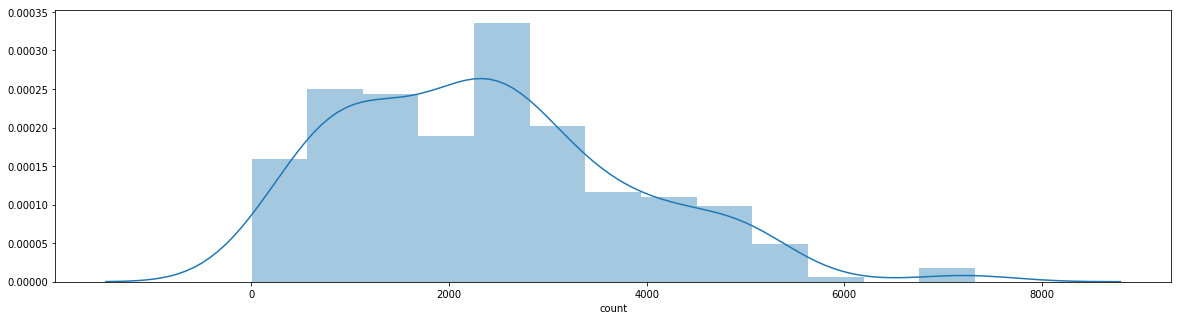

In [8]:
plt.figure(figsize=(20,5))
sns.distplot(trip_counts);
plt.show()

# plt.title('Destination Cell Counts - Top 50')
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Destination Cell ID', fontsize=12,rotation='horizontal')
# plt.xticks(rotation=90)
# plt.savefig('../output/EDA/Destination_Cell_Counts_Top_50.png')
# plt.show()

In [ ]:
hourly = data_014391.resample('H').sum()


In [10]:
total_trip_counts = dockless_data.groupby('Start Time').count()['count']

In [11]:
total_trip_counts.head(5)

Start Time
2018-04-04 15:45:00    1
2018-04-05 11:30:00    1
2018-04-05 11:45:00    2
2018-04-05 13:15:00    2
2018-04-05 13:45:00    1
Name: count, dtype: int64

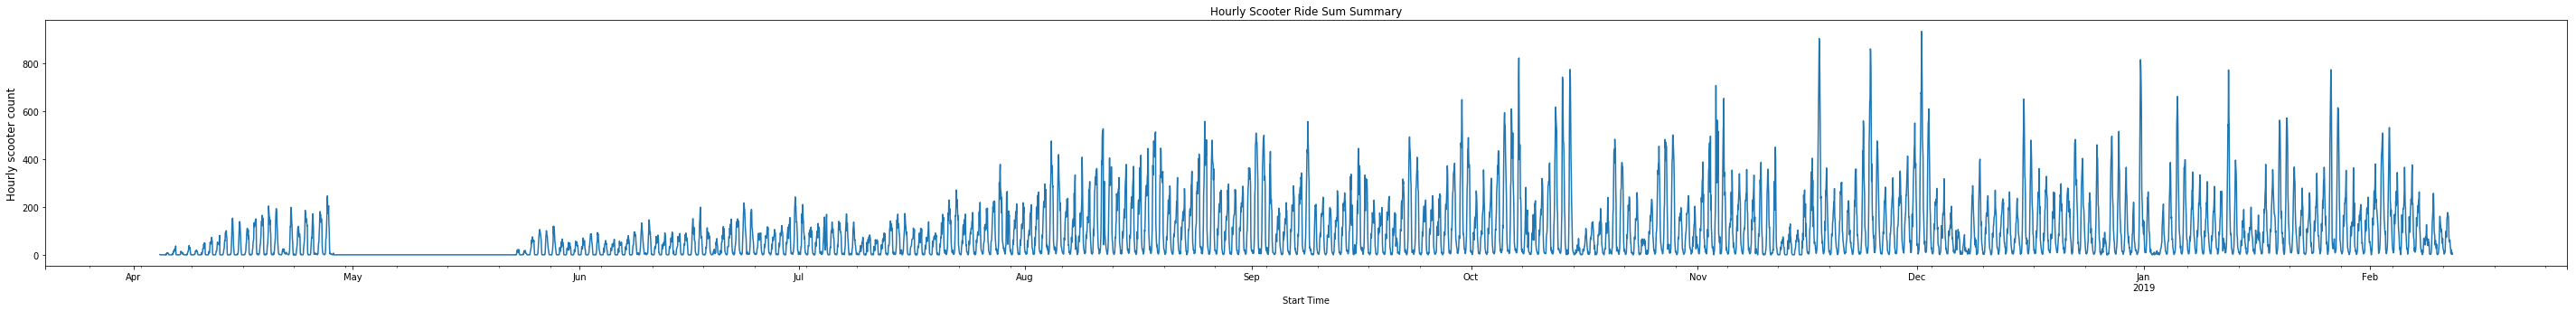

In [16]:
hourly = total_trip_counts.resample('H').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 5))
plt.title('Hourly Scooter Ride Sum Summary')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/Hourly_Scooter_Total_expanded.png')

In [13]:
hourly.max()

934

In [15]:
hourly[hourly==(hourly.max())]

Start Time
2018-12-01 15:00:00    934
Freq: H, Name: count, dtype: int64

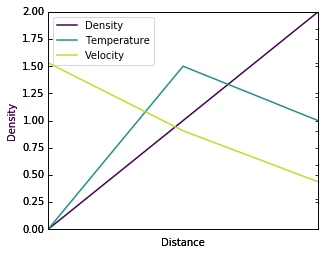

In [18]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt


#figsize=(50, 5))
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

host.set_xlim(0, 2)
host.set_ylim(0, 2)
par1.set_ylim(0, 4)
par2.set_ylim(1, 65)

host.set_xlabel("Distance")
host.set_ylabel("Density")
par1.set_ylabel("Temperature")
par2.set_ylabel("Velocity")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

p1, = host.plot([0, 1, 2], [0, 1, 2], color=color1,label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], color=color2, label="Temperature")
p3, = par2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      
# no x-ticks                 
par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

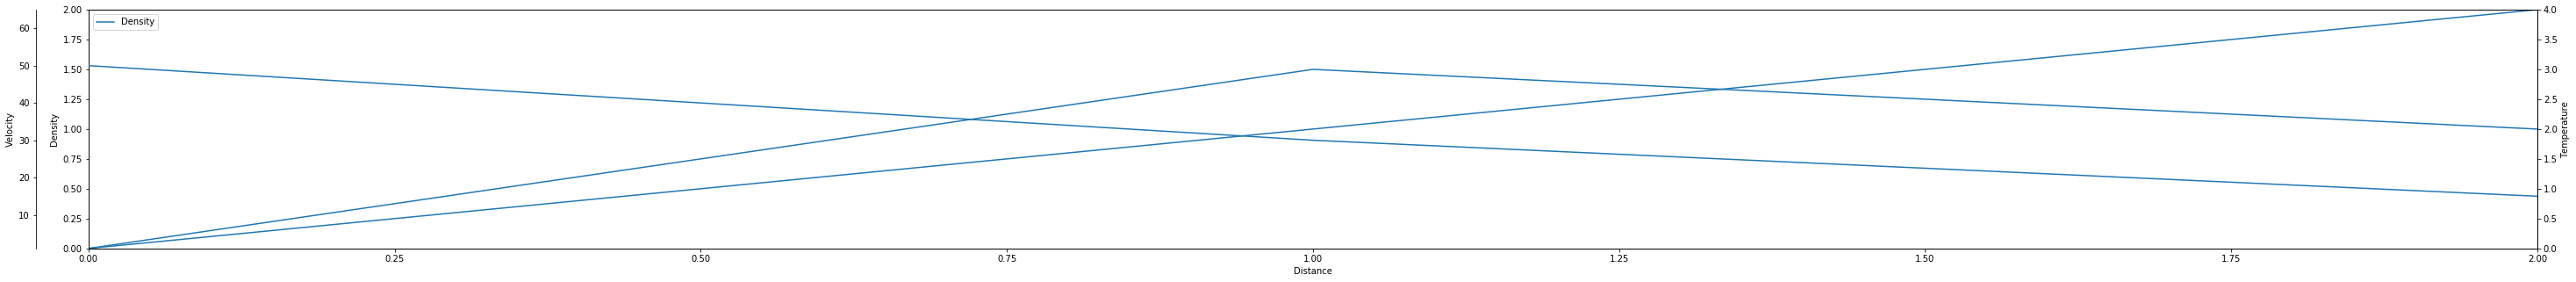

In [31]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

#host = host_subplot(111, axes_class=AA.Axes)

fig, host = plt.subplots(nrows=1, ncols=1,figsize=(50, 5))
#plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
# new_fixed_axis = par2.get_grid_helper().new_fixed_axis
# par2.axis["right"] = new_fixed_axis(loc="right", axes=par2, offset=(offset, 0))
# par2.axis["right"].toggle(all=True)

host.set_xlim(0, 2)
host.set_ylim(0, 2)

host.set_xlabel("Distance")
host.set_ylabel("Density")
par1.set_ylabel("Temperature")
par2.set_ylabel("Velocity")

par2.spines['left'].set_position(('outward', 60)) 
par2.spines["left"].set_visible(True) 
par2.yaxis.set_label_position('left') 
par2.yaxis.set_ticks_position('left')

p1, = host.plot([0, 1, 2], [0, 1, 2], label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], label="Temperature")
p3, = par2.plot([0, 1, 2], [50, 30, 15], label="Velocity")

par1.set_ylim(0, 4)
par2.set_ylim(1, 65)

host.legend()

# host.axis["left"].label.set_color(p1.get_color())
# par1.axis["right"].label.set_color(p2.get_color())
# par2.axis["right"].label.set_color(p3.get_color())


plt.show()

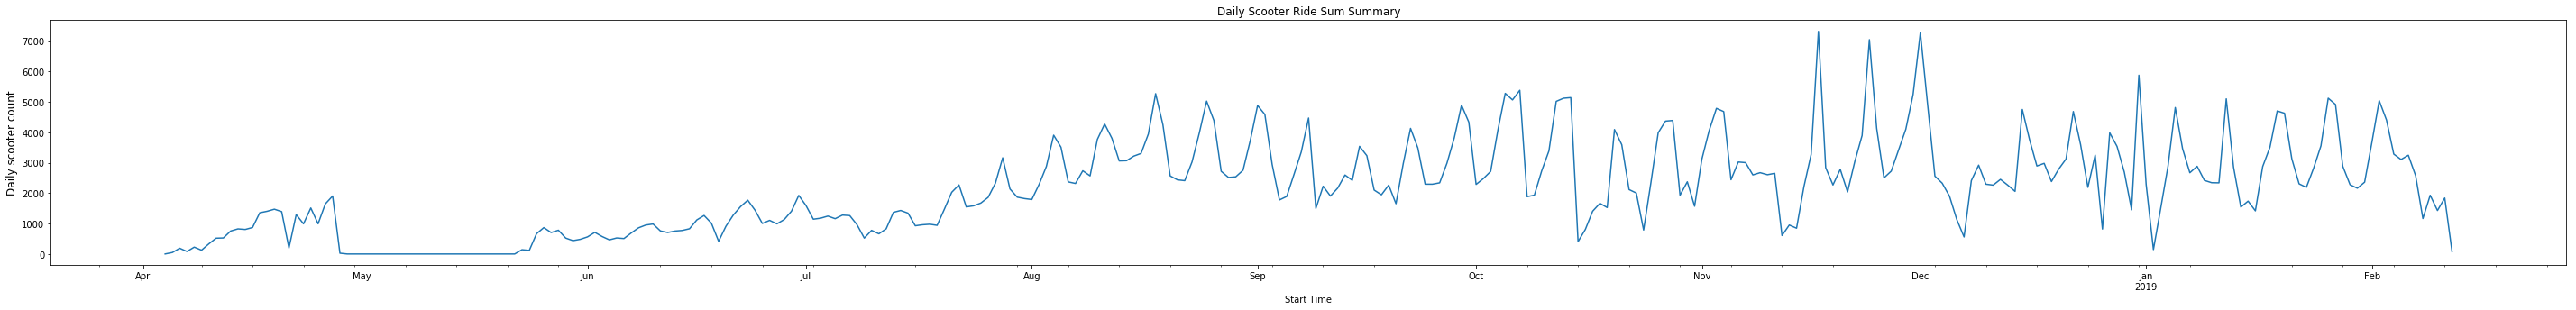

In [34]:
daily = total_trip_counts.resample('D').sum()
daily.plot(style=['-', '--', ':'],figsize=(50, 5))
plt.title('Daily Scooter Ride Sum Summary')
plt.ylabel('Daily scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/D_Scooter_Total_expanded.png')

In [38]:
type(daily)

pandas.core.series.Series